# Joint histograms of cold point temp and brightness temperature for the obs climo

In [1]:
import dask
import pickle

import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from dask.diagnostics import ProgressBar
from matplotlib import cm


In [2]:
file_path = "/work/bb1153/b380887/big_obs_climo/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/tb_cp_hists/"
pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/climo_tb_cp_hists//"


In [3]:
season = "DJF"


In [4]:
if season == "DJF":
    region_list = ["AMZ", "ECP", "IOS", "SPC"]
    year_list = [2007, 2008, 2009, 2010]
    offset_dict = {
        "AMZ": 9,
        "SPC": 10,
        "IOS": 9,
        "ECP": 10
    }

elif season == "JJA":
    region_list = ["AFR", "ECP", "WPC", "IOE"]
    year_list = [2007, 2008, 2009, 2010] # TODO: add 2006 when done
    offset_dict = {
        "AFR": 10,
        "WPC": 11,
        "IOE": 8,
        "ECP": 8
    }
    
years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)


2007-2010


## Get the joint climatology histogram

In [5]:
hist_region_dict = {}

for region in region_list:
    hist_computed_list = [[]]*len(year_list)
    nan_len_list = [[]]*len(year_list)

    for i, year in enumerate(year_list):
        if region == "SPC":
            with open(pickle_dir + "Tb-cpT_hist_dict_{s}{y}_{r}1.pickle".format(s=season, y=year, r=region), "rb") as handle:
                hist_dict_yr_1 = pickle.load(handle) 
            with open(pickle_dir + "Tb-cpT_hist_dict_{s}{y}_{r}2.pickle".format(s=season, y=year, r=region), "rb") as handle:
                hist_dict_yr_2 = pickle.load(handle)
            hist_computed_list[i] = np.sum([hist_dict_yr_1["hist_computed"], hist_dict_yr_2["hist_computed"]], axis=0)
            nan_len_list[i] = hist_dict_yr_1["nan_len"] + hist_dict_yr_2["nan_len"]
        else:
            with open(pickle_dir + "Tb-cpT_hist_dict_{s}{y}_{r}.pickle".format(s=season, y=year, r=region), "rb") as handle:
                hist_dict_yr = pickle.load(handle)
            hist_computed_list[i] = hist_dict_yr["hist_computed"]
            nan_len_list[i] = hist_dict_yr["nan_len"]

    # sum across years
    nan_len = sum(nan_len_list)
    hist_computed = np.sum(hist_computed_list, axis=0)

    # take bins & edges from the last dict in list
    hist_dict = {
        "hist_computed": hist_computed, 
        "xedges": hist_dict_yr["xedges"], 
        "yedges": hist_dict_yr["yedges"], 
        "tb_bins": hist_dict_yr["tb_bins"], 
        "cpT_bins": hist_dict_yr["cpT_bins"],
        "nan_len": nan_len,
    }

    hist_region_dict[region] = hist_dict


## Make the plots

In [6]:
def tb_cp_hist(hist_dict, season, region, years_str, plot_type, offset=None, colormap="viridis", linecol="k",
               levels=np.arange(-6, -1), figsize=(6, 4), fsize=14, tsize=16, save=False, Tb_limit=None):
    """ 
    Calculate and plot joint histogram of brightness temperature and cold point temperature.
    Can do pcolormesh (plot_type = "pcolormesh") or filled contours (plot_type = "contourf").
    """
    nan_len = hist_dict["nan_len"]
    hist_computed = hist_dict["hist_computed"]
    xedges = hist_dict["xedges"]
    yedges = hist_dict["yedges"]
    tb_bins = hist_dict["tb_bins"]
    cpT_bins = hist_dict["cpT_bins"]

    hist_normed = hist_computed/nan_len # normalized bin count
    xbin_means, ybin_means = (xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2
    hist_normed_nonzero = np.where(hist_normed > 0, hist_normed, np.nan)

    # plot
    fig, ax = plt.subplots(figsize=figsize)

    if plot_type == "pcolormesh":
        csn = ax.pcolormesh(xbin_means, ybin_means, np.log10(hist_normed_nonzero.T),  
                          vmin=levels[0], vmax=levels[-1])
        cb = plt.colorbar(csn, ax=ax, extend="both")
    elif plot_type == "contourf":
        ax.grid(linestyle=":", color="gray")
        if levels is None:
            csn = ax.contourf(xbin_means, ybin_means, np.log10(hist_normed_nonzero.T), extend='both',
                             cmap=colormap)
        else:
            csn = ax.contourf(xbin_means, ybin_means, np.log10(hist_normed_nonzero.T), extend='both', levels=levels, 
                              vmin=levels[0], vmax=levels[-1], cmap=colormap)
        ax.contour(csn, colors='k', linestyles='solid', linewidths=1) # to add the black lines to outline the contours
        cb = plt.colorbar(csn, ax=ax)
    
    cb.set_label("log$_{10}$(PDF)", fontsize=fsize-1)
    ax.set_xlabel("Cold Point (K)", fontsize=fsize)
    ax.set_ylabel("Brightness Temperature (K)", fontsize=fsize)
    cb.ax.tick_params(axis="y", labelsize=fsize-2)
    ax.tick_params(axis="both", labelsize=fsize-2)
    ax.set_title("{s} {y} ({r})".format(s=season, y=years_str, r=region), fontsize=tsize)
    ax.set_ylim((tb_bins[0], tb_bins[-1]))
    ax.set_xlim((cpT_bins[0], cpT_bins[-1]))
    
    # offset line (Tb = cp + offset) and 1-1 Tb=cp line
    ax.plot(cpT_bins, cpT_bins, color=linecol, linestyle="-", linewidth=2)
    if offset is not None:
        ax.plot(cpT_bins, [x+offset for x in cpT_bins], color=linecol, linestyle="--", linewidth=2)
    
    # save
    if save:
        plt.savefig(save_dir + "Tb_cpT_joint_hists_{s}{y}_{r}.png".format(s=season, y=years_str, r=region), dpi=300, bbox_inches="tight")
    
    plt.show()
    

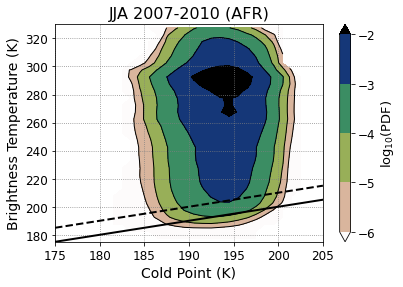

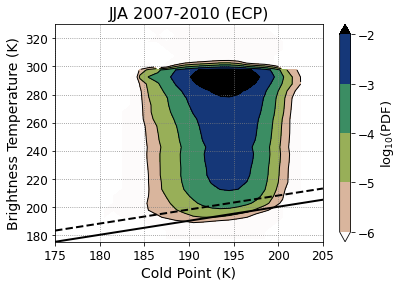

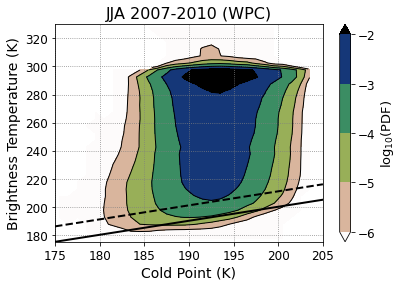

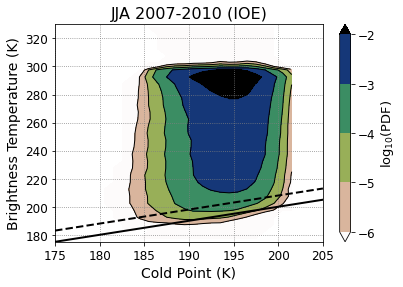

In [11]:
# JJA
for region in region_list:
    tb_cp_hist(hist_region_dict[region], season, region, years_str, "contourf", 
               offset=offset_dict[region], save=True, colormap=cm.gist_earth_r, linecol="k")


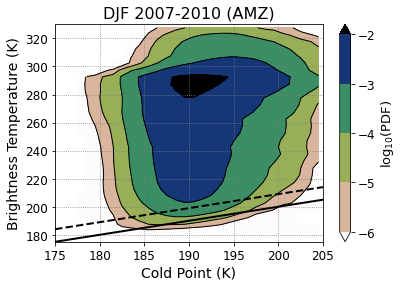

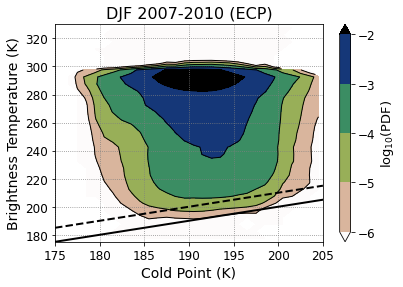

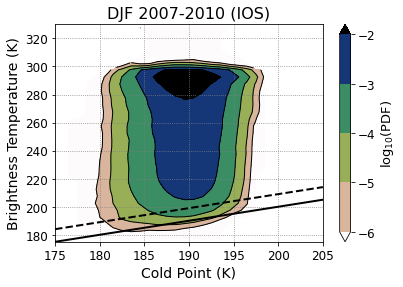

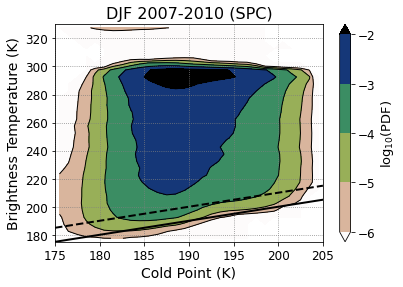

In [7]:
# DJF
for region in region_list:
    tb_cp_hist(hist_region_dict[region], season, region, years_str, "contourf", 
               offset=offset_dict[region], save=True, colormap=cm.gist_earth_r, linecol="k")
